# LEMKE- HOWSON
[Assignment 1] We focus on perturbations over payoffs. You are required to study how the equilibria of a game vary once some payoff of the matrix is perturbed. For instance, given the following game

(1,1) (0,0)

(0,0) (0,0)

a perturbation can be:

(1,1) (0,0)

(0,0) (e,e)

where e > 0 is arbitrarily close to zero. You will be required to understand how the best-response regions vary as perturbation e varies (in particular, studying the regions and their labels used by the Lemke-Howson algorithm) and how the set of equilibria changes (e.g., new equilibria may appear, some equilibria may collapse to a single equilibrium, some equilibria may disappear). 

In [71]:
from amplpy import AMPL
import pandas as pd

In [72]:
# Nash equilibrium function
def nash_equilibrium(players, actions, **kwargs):
    # Initialize AMPL
    ampl = AMPL()
    
    # AMPl for data
    I = actions
    P = players

    U = {player: kwargs['U' + str(player)] for player in P}
    
    # AMPL for model
    ampl.eval(r"""
        set P; # Players
        set I; # Actions
        
        param U1 {I, I};
        param U2 {I, I};
        param M{P};
        
        var s1 {I} >= 0;
        var s2 {I} >= 0;
        var b1 {I} binary;
        var b2 {I} binary;
        var v{P};
        
        subject to cons1_1{i in I}: s1[i] - b1[i] <= 0;
        subject to cons1_2{i in I}: s2[i] - b2[i] <= 0;
        
        subject to cons2_1{i in I}: v[1] - sum{j in I} (U1[i,j] * s2[j]) - M[1]*(1-b1[i]) <= 0;
        subject to cons2_2{j in I}: v[2] - sum{i in I} (U2[i,j] * s1[i]) - M[2]*(1-b2[j]) <= 0;
        
        subject to cons3_1{i in I}: v[1] - sum{j in I} (U1[i,j] * s2[j]) >= 0;
        subject to cons3_2{j in I}: v[2] - sum{i in I} (U2[i,j] * s1[i]) >= 0;
        
        subject to sumToOne_1: sum{i in I} s1[i] == 1;
        subject to sumToOne_2: sum{j in I} s2[j] == 1;
        
        maximize obj: v[1] + v[2];
    """)

    ampl.set['P'] = P
    ampl.set['I'] = I

    U_df = {player: pd.DataFrame(U[player], index=I, columns=I) for player in P}
    
    for player in P:
        ampl.param['U' + str(player)] = U_df[player]

    ampl.param['M'] = {player: 1000 for player in P}

    # AMPL solver
    ampl.solve(solver='gurobi')
    assert ampl.solve_result == "solved"
    
    # return v and all the strategies
    s = {player: ampl.getVariable('s' + str(player)).getValues().toPandas() for player in P}
    v = ampl.getVariable('v').getValues().toPandas()
    
    # close AMPL
    ampl.close()
    
    return v, s

## Test

In [73]:


I = ["a1", "a2", "a3"]
P = [1, 2]


U1 = [[2,1,0], 
    [1,2,0],
    [0,0,0]]

U2 = [[1,2,0], 
    [2,1,0],
    [0,0,0]]

v, s = nash_equilibrium(players=P, actions=I, U1 = U1, U2 = U2)

print("Expected utility for players: ", v)
print("Player 1 strategy: ", s[1])
print("Player 2 strategy: ", s[2])

Gurobi 9.5.1: optimal solution; objective 3
16 simplex iterations
1 branch-and-cut nodes
plus 8 simplex iterations for intbasis
Expected utility for players:     v.val
1    1.5
2    1.5
Player 1 strategy:      s1.val
a1     0.5
a2     0.5
a3     0.0
Player 2 strategy:      s2.val
a1     0.5
a2     0.5
a3     0.0


## Best response regions (Assignment 1)

In [85]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from ipywidgets import Output
from ipywidgets import Layout
import numpy as np

In [88]:
# Define a function that updates the utility matrices when the slider value changes
def update_utility_matrices(e):
    
    # Define game here
    global U1, U2
    U1 = [[1,0], [0,e]]
    U2 = [[1,0], [0,e]]
    I = ["a1", "a2"]
    P = [1, 2]
    # ----------------
    
    v, s = nash_equilibrium(players=P, actions=I, U1=U1, U2=U2)
    
    # # Update widget values
    # label_utility.value = "Expected utility for players: " + str(v)
    # label_strategy.value = ""
    # for player in P:
    #     label_strategy.value += "Player " + str(player) + " strategy: " + str(s[player])

# Create widgets
# label_utility = widgets.Textarea()
# label_strategy = widgets.Textarea()

descrption_simplex_1_1 = widgets.Label(value="Green part means player 2 plays a1 there")

simplex_1_1 = widgets.FloatProgress(
    value=0, 
    min=0, 
    max=1, 
    step=0.1, 
    description='\sigma_1(a_2):', 
    bar_style='info', 
    orientation='horizontal',
    style={'description_width': 'initial'}
)

descrption_simplex_1_2 = widgets.Label(value="Green part means player 1 plays a1 there")

simplex_1_2 = widgets.FloatProgress(
    value=0, 
    min=0, 
    max=1, 
    step=0.1, 
    description='\sigma_2(a_2):', 
    bar_style='info', 
    orientation='horizontal',
    style={'description_width': 'initial'}
)


# Display widgets
# display(label_utility)
# display(label_strategy)
display(simplex_1_1)
display(simplex_1_2)



# Create a slider
e_slider = widgets.FloatSlider(
    value=0,
    min=0,
    max=100.0,
    step=0.1,
    description='e:',
    continuous_update=False
)

# Display the slider
display(e_slider)

# Update the utility matrices whenever the slider value changes
e_slider.observe(lambda change: update_utility_matrices(change['new']), names='value')

Textarea(value='')

Textarea(value='')

FloatProgress(value=0.0, bar_style='info', description='\\sigma_1(a_2):', max=1.0, style=ProgressStyle(descrip…

FloatProgress(value=0.0, bar_style='info', description='\\sigma_2(a_2):', max=1.0, style=ProgressStyle(descrip…

FloatSlider(value=0.0, continuous_update=False, description='e:')

In [76]:
I = ["a1", "a2"]
P = [1, 2]

In [77]:
# Function to plot a simplex
def simplex_1():
    pass
simplex_1()

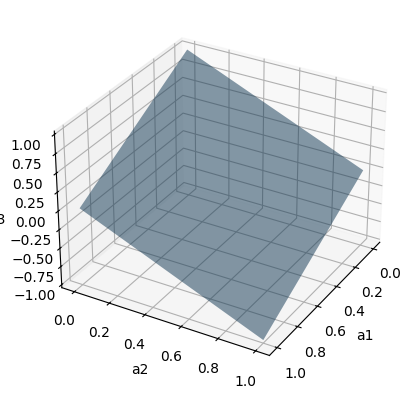

In [78]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_simplex(actions):
    if len(actions) != 3:
        raise ValueError("Simplex plot only supports 3 actions")

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel(actions[0])
    ax.set_ylabel(actions[1])
    ax.set_zlabel(actions[2])

    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    Z = 1 - X - Y

    ax.plot_surface(X, Y, Z, alpha=0.5, rstride=100, cstride=100)
    ax.view_init(elev=30, azim=30)  # Adjust the viewing angle

    plt.show()

plot_simplex(actions=["a1", "a2", "a3"])

# TEST

In [79]:
import numpy as np
from scipy.optimize import linprog

# Define payoff matrices (A and B) for players 1 and 2
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])

# Lemke-Howson algorithm
def lemke_howson(A, B):
    # Initialize with an initial vertex
    vertex = np.array([0.5, 0.5])
    while True:
        # Compute best responses for both players
        br1 = linprog(-A.T @ vertex).x
        br2 = linprog(-B @ vertex).x
        # Update vertex
        vertex = br1 + br2
        if np.allclose(vertex, br1) or np.allclose(vertex, br2):
            break
    return vertex

# Get Nash equilibrium
nash_eq = lemke_howson(A, B)
print("Nash equilibrium:", nash_eq)

# Plot best response regions
fig, ax = plt.subplots()
x = np.linspace(0, 1, 100)
y1 = (A[0, 0] - A[0, 1] * x) / A[0, 1]
y2 = (A[1, 0] - A[1, 1] * x) / A[1, 1]
ax.plot(x, y1, label="Player 1 best response")
ax.plot(x, y2, label="Player 2 best response")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()
plt.show()




TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'